In [1]:
#Importing all the packages

#Package for data manipulation and analysis
import pandas as pd
#adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level
#mathematical functions to operate on these arrays
import numpy as np
#Open source software library for advanced natural language  processing-Spacy package we used here is better than PorterStemmer, Snowball
import spacy
#small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary, syntax and entities.
import en_core_web_sm

In [2]:
#To read the input csv file
df=pd.read_csv("NonSpam1.csv") 

In [3]:
#used to get the first 5 rows.
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
#a tuple that always gives dimensions of the array
df.shape

(5171, 4)

In [5]:
#Number of missing values in the data set
df.isnull().sum(axis = 0)

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [6]:
# Run in terminal or command prompt
# python3 -m spacy download en
'''Genism is a open-source library for unsupervised topic modeling and natural language processing, using modern statistical machine 
learning
NLTK, is a suite of libraries and programs for symbolic and statistical natural language processing for English written 
'''
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# comprehensive library for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [8]:
#converting text column to list
data=df.text.values.tolist()

In [9]:
# Remove new line characters
data = [re.sub(r'\s+', ' ', sent) for sent in data]

In [10]:
# Remove distracting single quotes
data = [re.sub(r"\'", "", sent) for sent in data]

In [11]:
#printing email in row 1
pprint(data[:1])

['Subject: enron methanol ; meter # : 988291 this is a follow up to the note i '
 'gave you on monday , 4 / 3 / 00 { preliminary flow data provided by daren } '
 '. please override pop  s daily volume { presently zero } to reflect daily '
 'activity you can obtain from gas control . this change is needed asap for '
 'economics purposes .']


In [12]:
#Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, 
#symbols and other elements called tokens.(some characters like punctuation marks are discarded.)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['subject', 'enron', 'methanol', 'meter', 'this', 'is', 'follow', 'up', 'to', 'the', 'note', 'gave', 'you', 'on', 'monday', 'preliminary', 'flow', 'data', 'provided', 'by', 'daren', 'please', 'override', 'pop', 'daily', 'volume', 'presently', 'zero', 'to', 'reflect', 'daily', 'activity', 'you', 'can', 'obtain', 'from', 'gas', 'control', 'this', 'change', 'is', 'needed', 'asap', 'for', 'economics', 'purposes']]


In [13]:
'''Stemming is the process of reducing a word to its word stem that affixes to suffixes and 
prefixes or to the roots of words known as a lemma.
Lemmatization, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language'''

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [14]:
#en_core_web_sm is a small English pipeline trained on written web text (blogs, news, comments), that includes vocabulary,
#syntax and entities.
sp = spacy.load("en_core_web_sm")

In [15]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['methanol meter follow note give flow datum provide daren override pop volume reflect activity obtain gas control change need economics purpose', 'see attach file hplnol xls hplnol xls']


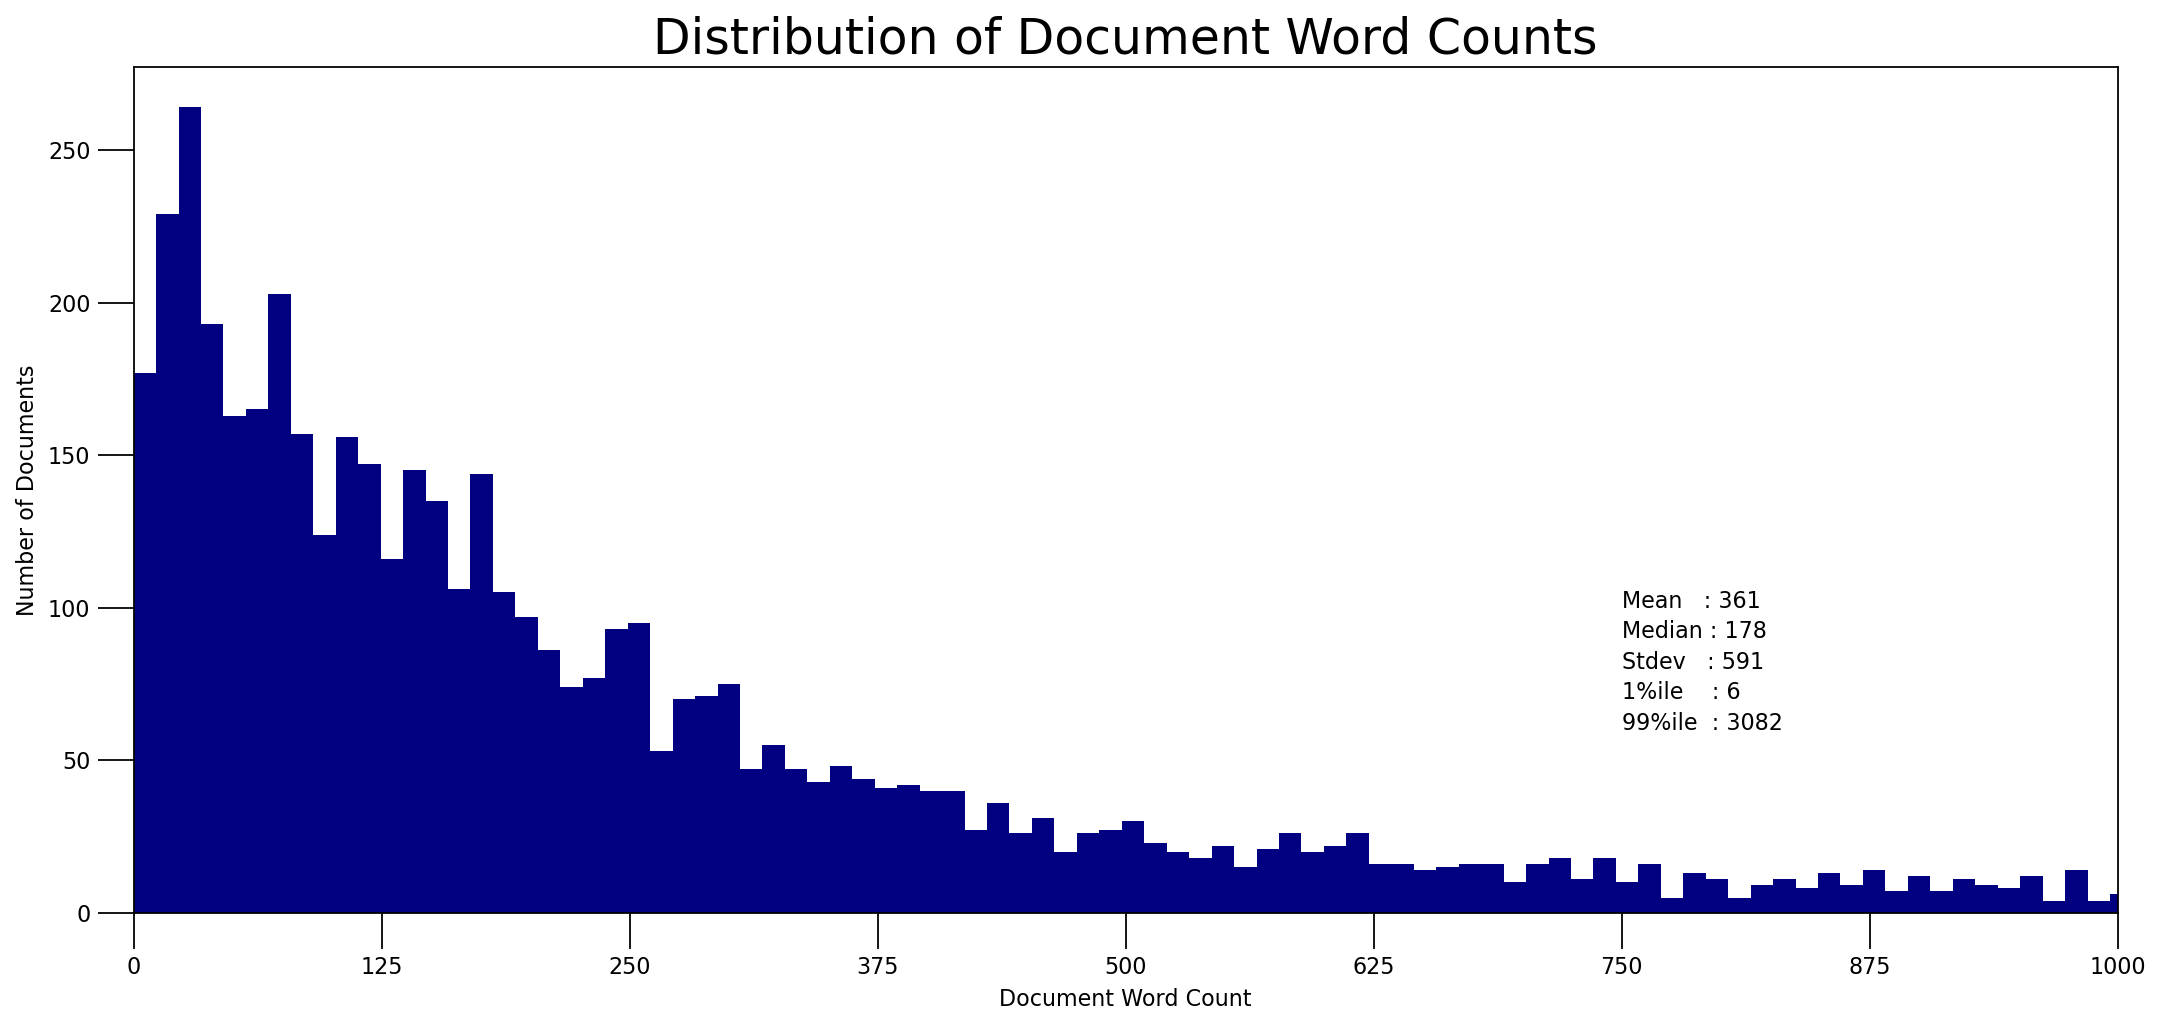

In [16]:
#Frequency Distribution of Word Counts in Documents

doc_lens = [len(d) for d in data_lemmatized]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=12)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [17]:
'''LDA topic model algorithm  requires a document word matrix as the main input.
Configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), remove built-in 
english stopwords, convert all words to lowercase, and a word can contain numbers and alphabets of at least length
3 in order to be qualified as a word'''
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  
# num chars > 3
                             # max_features=50000,             
# max number of uniqe words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [18]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [19]:
#Found best hyperparamters values and used in the model
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=10.0,
 max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
 n_components=10, n_jobs=-1, perp_tol=0.1,
 random_state=100, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)

In [20]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [21]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1332184.4892775281
Perplexity:  496.22683334617335
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [22]:
pip install pandas --upgrade

Requirement already up-to-date: pandas in c:\users\jgsan\anaconda3\lib\site-packages (1.3.4)
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style


In [24]:
df_document_topics = df_document_topic.head(15)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.00,0.51,0.00,0.45,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
Doc1,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.86,0.01,0.01,0.01,0.01,15
Doc2,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.85,0.02,18
Doc3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.13,0.46,0.01,0.01,0.30,0.01,0.01,14
Doc4,0.00,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.09,0.05,0.00,0.18,0.00,0.05,1
Doc5,0.00,0.00,0.47,0.23,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.27,0.00,0.00,2
Doc6,0.00,0.00,0.02,0.00,0.00,0.00,0.02,0.04,0.00,0.00,...,0.00,0.03,0.05,0.00,0.00,0.00,0.00,0.04,0.80,19
Doc7,0.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.00,0.14,...,0.00,0.30,0.00,0.09,0.00,0.12,0.00,0.00,0.00,5
Doc8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9
Doc9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.15,0.01,0.44,0.01,0.01,0.29,0.01,15


In [25]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

,ability,absence,abuse,accept,acceptance,access,accommodate,accomplish,accord,accordance,...,www,xanax,xls,yahoo,year,yesterday,yvette,zero,zone,zyban
Topic0,0.050004,0.050001,0.050001,5.434719,0.050004,0.050001,0.050001,4.295969,5.959740,0.050001,...,0.050001,0.050001,0.050001,0.050002,0.061199,2.459764,0.050001,29.552507,53.138904,0.050001
Topic1,0.050001,0.050002,0.050001,0.050010,0.050001,0.050001,0.050001,0.050020,37.756156,0.050001,...,0.050001,0.050001,0.050001,0.050001,1.656916,20.356772,0.050001,23.105630,4.261973,0.050001
Topic2,0.050002,0.050001,0.050001,0.050002,0.050002,17.428038,0.050015,0.050002,0.050001,0.050001,...,0.050001,0.050001,0.050001,0.050001,3.643325,0.050001,0.050001,0.050001,1.839041,0.050001
Topic3,0.050198,0.050010,0.050002,17.416676,9.325391,185.235897,0.050002,0.050044,5.036986,0.050034,...,0.050006,0.050001,0.050023,0.050006,156.178675,0.707726,45.914316,0.050001,0.050026,0.050001
Topic4,0.050001,24.191156,0.050001,0.050214,0.050001,0.050023,0.050003,0.050003,0.050001,0.050001,...,0.050001,0.050001,0.050001,0.050001,0.050157,0.050001,0.050001,0.050001,0.050001,0.050001


In [26]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,gas,deal,contract,meter,purchase,transport,oil,volume,energy,ticket,agreement,spot,price,path,mmbtu
Topic 1,deal,meter,volume,thank,gas,day,daren,subject,flow,know,sale,need,let,farmer,ticket
Topic 2,com,remove,contact,mail,link,message,list,availability,sale,email,reply,line,owner,copy,send
Topic 3,information,contact,use,number,report,employee,process,question,note,request,provide,list,team,receive,survey
Topic 4,meeting,schedule,outage,time,sit,training,attend,server,koch,subject,environment,begin,location,impact,room
Topic 5,pill,subject,prescription,med,viagra,health,pain,cornhusker,man,doctor,medication,woman,need,stop,weight
Topic 6,com,message,send,mail,aol,subject,email,hotmail,home,content,image,address,net,reply,gift
Topic 7,order,product,customer,hour,change,password,user,tab,price,stack,click,website,manager,button,thank
Topic 8,height,size,font,width,face,border,color,center,src,style,line,family,table,align,info
Topic 9,mmbtu,nomination,gas,actual,com,flow,eastran,rate,revise,fuel,delivery,day,subject,forward,nom


In [29]:
df_topic_keywords.head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,gas,deal,contract,meter,purchase,transport,oil,volume,energy,ticket,agreement,spot,price,path,mmbtu,Purchase
Topic 1,deal,meter,volume,thank,gas,day,daren,subject,flow,know,sale,need,let,farmer,ticket,Exigency
Topic 2,com,remove,contact,mail,link,message,list,availability,sale,email,reply,line,owner,copy,send,Contact/Support
Topic 3,information,contact,use,number,report,employee,process,question,note,request,provide,list,team,receive,survey,Requisition
Topic 4,meeting,schedule,outage,time,sit,training,attend,server,koch,subject,environment,begin,location,impact,room,Notification


In [28]:
Topics = ["Purchase","Exigency","Contact/Support","Requisition","Notification", 
          "Health/wellness", "Basic Details", "Order processing", "Documentation", 
          "Delivery details","Personal details","Allocation","Frontend","Software",
          "Stock information","Operation","Transaction","Process","Time period","Travelling"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,gas,deal,contract,meter,purchase,transport,oil,volume,energy,ticket,agreement,spot,price,path,mmbtu,Purchase
Topic 1,deal,meter,volume,thank,gas,day,daren,subject,flow,know,sale,need,let,farmer,ticket,Exigency
Topic 2,com,remove,contact,mail,link,message,list,availability,sale,email,reply,line,owner,copy,send,Contact/Support
Topic 3,information,contact,use,number,report,employee,process,question,note,request,provide,list,team,receive,survey,Requisition
Topic 4,meeting,schedule,outage,time,sit,training,attend,server,koch,subject,environment,begin,location,impact,room,Notification
Topic 5,pill,subject,prescription,med,viagra,health,pain,cornhusker,man,doctor,medication,woman,need,stop,weight,Health/wellness
Topic 6,com,message,send,mail,aol,subject,email,hotmail,home,content,image,address,net,reply,gift,Basic Details
Topic 7,order,product,customer,hour,change,password,user,tab,price,stack,click,website,manager,button,thank,Order processing
Topic 8,height,size,font,width,face,border,color,center,src,style,line,family,table,align,info,Documentation
Topic 9,mmbtu,nomination,gas,actual,com,flow,eastran,rate,revise,fuel,delivery,day,subject,forward,nom,Delivery details


In [30]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: pillow in c:\users\jgsan\anaconda3\lib\site-packages (from wordcloud) (8.0.1)



In [31]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jgsan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
stop = set(stopwords.words('english'))
stop.update(['Word','Topic','forward'])

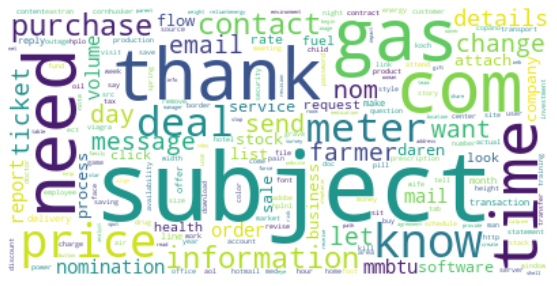

In [33]:
wordcloud = WordCloud( stopwords = stop, max_font_size=70, background_color="white").generate(str(df_topic_keywords))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["tomorrow, i would like to refine this spreadsheet and try to support some of the population and job growth assumptions with more current data.let me know what you think."]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)


['know', 'thank', 'let', 'change', 'subject', 'farmer', 'send', 'daren', 'deal', 'desk', 'message', 'think', 'want']
Process


In [36]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
df["Topic_key_word"]= df['text'].apply(apply_predict_topic)
df.head()

,Unnamed: 0,label,text,label_num,Topic_key_word
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,Exigency
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,Operation
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,Time period
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,Stock information
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,Exigency


In [37]:
df.drop(['Unnamed: 0', 'label_num'], axis = 1)

,label,text,Topic_key_word
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,Exigency
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",Operation
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",Time period
3,spam,"Subject: photoshop , windows , office . cheap ...",Stock information
4,ham,Subject: re : indian springs\r\nthis deal is t...,Exigency
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,Delivery details
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,Delivery details
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,Operation
5169,ham,Subject: industrial worksheets for august 2000...,Process


In [38]:
df.groupby("Topic_key_word").nunique()

,Unnamed: 0,label,text,label_num
Topic_key_word,,,,
Allocation,163,2,158,2
Basic Details,120,2,119,2
Contact/Support,112,2,109,2
Delivery details,579,2,573,2
Documentation,33,2,33,2
Exigency,760,2,759,2
Frontend,700,2,694,2
Health/wellness,235,2,213,2
Notification,66,2,62,2


In [ ]:
# df.to_csv("FinalTopic_Result.csv")

In [39]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.26  0.7   0.04  0.15  0.05  0.06  0.06  0.04  0.02  0.4   0.04  0.12
   0.16  0.05  0.06  0.21  0.04  0.36  0.12  0.03]
 [-0.06 -0.49  0.02  0.02  0.01  0.03  0.03  0.02  0.01  0.85  0.01 -0.03
   0.09  0.02  0.02  0.13  0.01 -0.08  0.01  0.02]]
Perc of Variance Explained: 
 [0.06 0.16]


In [40]:
df.head(10)

,Unnamed: 0,label,text,label_num,Topic_key_word
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,Exigency
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,Operation
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,Time period
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1,Stock information
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0,Exigency
5,2949,ham,Subject: ehronline web address change\r\nthis ...,0,Contact/Support
6,2793,ham,Subject: spring savings certificate - take 30 ...,0,Travelling
7,4185,spam,Subject: looking for medication ? we ` re the ...,1,Frontend
8,2641,ham,Subject: noms / actual flow for 2 / 26\r\nwe a...,0,Delivery details
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0,Operation


Text(0.5, 1.0, 'Segregation of Topic Clusters')

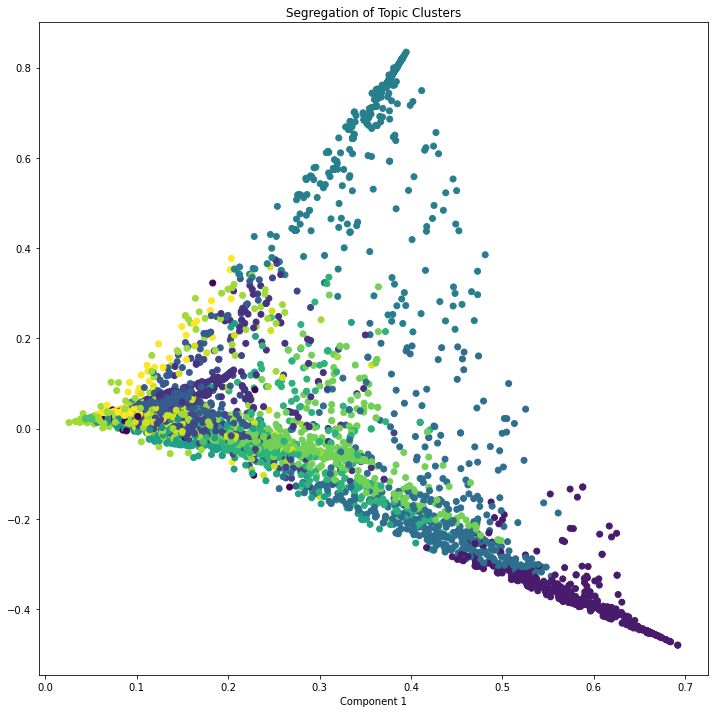

In [41]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [42]:
import joblib

joblib.dump(lda_model, 'lda_model.jl')
# then reload it with
lda_model = joblib.load('lda_model.jl')


## Data Visualisation

In [43]:
!pip3 install pyLDAvis

In [44]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [45]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\jgsan\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\jgsan\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Users\jgsan\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
14     -10.878068   10.538728       1        1  12.944192
1      -60.884026  -75.591820       2        1  11.188049
17      -2.336119  -53.289074       3        1   9.643891
3      -61.385319  -12.914634       4        1   9.422659
0      -28.737743  126.296997       5        1   8.850229
12       1.066606 -123.552811       6        1   7.435590
11      45.140720   -7.947869       7        1   5.254826
9     -140.795975  -98.530548       8        1   4.386852
18      61.531681  -83.240562       9        1   4.332944
2      -72.563057 -140.396881      10        1   3.734883
16      15.984491   63.578186      11        1   3.255555
6     -160.851624   68.945145      12        1   3.098745
7       85.961830   51.922935      13        1   2.985359
13     -99.020836  109.936348      14        1   2.659686
15    -176.764130   -8.681684      15        1   2.350483
5     -117.189880  -37.420200      16        1   2.231361
4      108.829918  -22.946203      17        1   1.961912
8       47.588097  121.934814      18        1   1.754601
10    -106.467834   30.176889      19        1   1.642587
19     -50.613804   59.328842      20        1   0.865597, topic_info=          Term         Freq        Total Category  logprob  loglift
634        ect  3487.000000  3487.000000  Default  30.0000  30.0000
355        com  3263.000000  3263.000000  Default  29.0000  29.0000
841        gas  2841.000000  2841.000000  Default  28.0000  28.0000
504       deal  3452.000000  3452.000000  Default  27.0000  27.0000
1215     meter  2381.000000  2381.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1517  purchase    41.233224   679.781925  Topic20  -3.8079   1.9470
337      click    29.117815   448.311870  Topic20  -4.1558   2.0154
819    forward    25.445224  1366.682099  Topic20  -4.2906   0.7659
2011       use    23.727390   940.609104  Topic20  -4.3605   1.0696
1299     offer    20.482613   522.454491  Topic20  -4.5076   1.5105

[1198 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.557570  ability
0        13  0.433665  ability
1        17  0.962115  absence
2        11  0.960536    abuse
5         1  0.046196   access
...     ...       ...      ...
2110     10  0.008073     year
2110     11  0.018164     year
2110     14  0.020182     year
2110     19  0.034310     year
2112      4  0.985618   yvette

[2572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 2, 18, 4, 1, 13, 12, 10, 19, 3, 17, 7, 8, 14, 16, 6, 5, 9, 11, 20])